# **GNNs Using Python: Chapter 04 - Node Embeddings: Biased Random Walks & Node2Vec**

*Author: Rafael Rodríguez Palomo*

*January, 2024*

In [82]:
from gensim.models.word2vec import Word2Vec
import spacy
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.pipeline import Pipeline

## **Node2Vec Architecture**

Node2Vec aim to obtain representative node embeddings based on the same components as DeepWalk (random walks and Word2Vec). The main difference is in how the random walks are generated.

Instead of considering a uniform distribution to choose the next node in the walk we want to be able to bias the random walks, but first we need to understand the concept of **neighborhood**.

### Neighborhood of a Node

In simple words, the neighborhood of a node is something that is close to that node. With random walks we want to explore the neighborhood of a specific node.

Depending on how we perform this exploration we can identify two different **sampling strategies**:
- Explore the closest nodes in terms of connections (**BFS**), thus focusing on the local network around the node.
- Explore nodes that are not adjacent to previous nodes (**DFS**), thus getting a better view of the graph as a whole.

DeepWalk implements the BFS search so it only focuses on structural equivalence, however the best approach is to create random walks that are able to take into account both structural equivalence and and far away nodes.





### How to Bias a Random Walk

So our goal in Node2Vec is to bias a the random walks to promote nodes that are not connected to the previous one (DFS) or to promote nodes that are far away from the previous one (DFS). We can do this by means of probabilities.

We can define the unnormalized probability of transitioning from node $j$ to $k$ as:

\begin{align*}
\pi_{jk} = \alpha(i, k)*w_{jk}
\end{align*}

where:
- $j$ is the current node.
- $k$ is the future node.
- $i$ is the previous node.
- $\alpha(i, k)$ is the search bias between nodes $i$ and $k$.
- $w_{jk}$ is the weight of the edge in case we are working with weighted graphs.

We can define the search bias $\alpha(i,k)$ as:

\begin{align*}
\alpha(i, k) =
\begin{cases}
\ 1/p & \text{if } d_{ik} = 0 \\
\ 1 & \text{if } d_{ik} = 1 \\
\ 1/q & \text{if } d_{ik} = 2 \\
\end{cases}
\end{align*}

where:
- $p$ controls the probability of going back to the previous node.
- $q$ controls the probability of exploring nodes that are not connected to node $i$.
- $d_{ik}$ is the shortest distance between nodes $i$ and $k$.

Note that if both $p$ and $q$ are equel to $1$ we are defining the same probability for every node so we get the same results as in DeepWalk.



As an example we use the same Karate Club dataset used in the previous notebook.

In [42]:
# Extract labels and print graph
karate_graph = nx.karate_club_graph()
labels = np.array([1 if karate_graph.nodes[node]['club'] == 'Officer' else 0 for node in karate_graph.nodes])

print(f"Number of Club 1 members: {np.sum(labels)}")
print(f"Number of Club 2 members: {len(labels) - np.sum(labels)}")

Number of Club 1 members: 17
Number of Club 2 members: 17


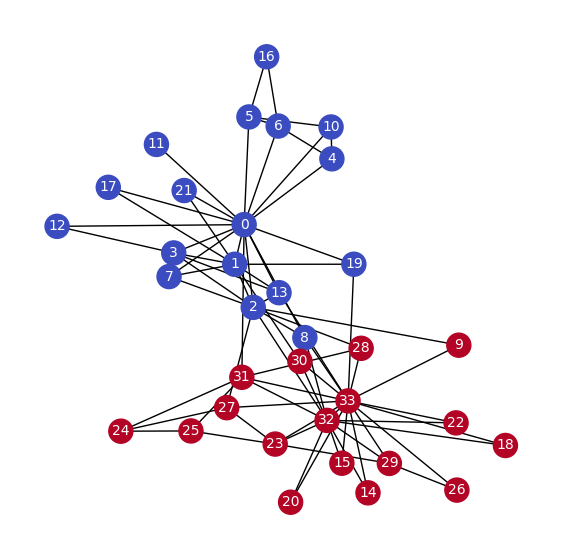

In [43]:
plt.figure(figsize=(7, 7))
plt.axis('off')
nx.draw_networkx(karate_graph, pos=nx.spring_layout(karate_graph, seed=0), cmap='coolwarm',
                 node_color=labels, font_size=10, font_color='white')

Now we have to implement the new biased random walk function using the above expressions.

In [97]:
def biased_random_walk(start_node, graph, elements, p=0.5, q=0.5):
  walk = [str(start_node)]
  previous_nodes = [start_node]
  node = start_node

  for i in range(elements):
    neighbors = list(graph.neighbors(node))
    alphas = []

    # Now we assign an alpha for each neighboring node
    for neighbor in neighbors:
      if previous_nodes[-1] == neighbor:
        alpha = 1/p
      elif graph.has_edge(previous_nodes[-1], neighbor):
        alpha = 1
      else:
        alpha = 1/q
      alphas.append(alpha)

    probs = np.array(alphas) / np.sum(alphas) # Normalize to get probs

    # Now we select a node given the calculated probabilities
    chosen = np.random.choice(neighbors, 1, p=probs)[0]
    walk.append(str(chosen))
    previous_nodes.append(node)
    node = chosen

  return walk

In [98]:
# Generate 100 walks for each node with 10 elements per walk
# We can play with p and q to bias the walk
n_walks = 100
n_elements = 10
walks = [biased_random_walk(node, karate_graph, n_elements, p=1, q=1) for node in karate_graph.nodes for i in range(n_walks)]

# Print an example
print(f"Total number of walks: {len(walks)}")
print(walks[0])
print(walks[1])

Total number of walks: 3400
['0', '19', '33', '15', '32', '31', '32', '23', '29', '32', '14']
['0', '21', '0', '1', '2', '1', '21', '1', '2', '13', '3']


The remaining implementation is the same as in DeepWalk. Now, as we want to compare DeepWalk and Node2Vec we create a class that implements the whole Node2Vec algorithm.

In [93]:
# Class compatible with Scikit-learn
class Node2VecCustom(BaseEstimator, TransformerMixin):
  def __init__(self, walk_length, num_walks_per_node, window_size, vector_size, p, q, sg=1, seed=None):
    self.walk_length = walk_length
    self.num_walks_per_node = num_walks_per_node
    self.sg = sg
    self.window_size = window_size
    self.vector_size = vector_size
    self.seed = seed

    self.p = p
    self.q = q

    self.word2vec = None
    self.node_order = None

  def __create_walks(self, start_node, graph):
    walk = [str(start_node)]
    previous_nodes = [start_node]
    node = start_node

    for i in range(self.walk_length):
      neighbors = list(graph.neighbors(node))
      alphas = []

      # Now we assign an alpha for each neighboring node
      for neighbor in neighbors:
        if previous_nodes[-1] == neighbor:
          alpha = 1/self.p
        elif graph.has_edge(previous_nodes[-1], neighbor):
          alpha = 1
        else:
          alpha = 1/self.q
        alphas.append(alpha)

      probs = np.array(alphas) / np.sum(alphas) # Normalize to get probs

      # Now we select a node given the calculated probabilities
      chosen = np.random.choice(neighbors, 1, p=probs)[0]
      walk.append(str(chosen))
      previous_nodes.append(node)
      node = chosen

    return walk

  def fit(self, X, y=None):
    walks = [self.__create_walks(node, X) for node in X.nodes for i in range(self.num_walks_per_node)]
    self.word2vec = Word2Vec(walks, sg=self.sg, window=self.window_size, vector_size=self.vector_size, seed=self.seed)
    self.word2vec.train(walks, total_examples=self.word2vec.corpus_count, epochs=50, report_delay=1)
    self.node_order = list(self.word2vec.wv.key_to_index.keys())

    self.is_fitted_ = True

    return self

  def transform(self, X):
    # This has a lot of room for improvement (temp solution)
    # Word2Vec is not able to handle OOV words so we should check that X is the same graph passed to the fit function
    # check_is_fitted(self)
    embeddings_unordered = self.word2vec.wv.vectors

    # Order nodes
    node_order_arr = np.array(self.node_order).reshape(-1, 1)
    embed_label_unordered = np.hstack((embeddings_unordered, node_order_arr))
    order_idx = np.argsort(embed_label_unordered[:, -1].astype(int))
    embed_label_ordered = embed_label_unordered[order_idx]
    embeddings = embed_label_ordered[:,:-1]

    return embeddings.astype(float)

  def fit_transform(self, X, y=None, **fit_params):
    self.fit(X, y)
    return self.transform(X)

Once the class is defined we run a DeepWalk model with a KNN classifier to get a baseline performance. To filter out the stochastic effect of the random walks we run 100 tests and print the average accuracy.

In [94]:
# Train test split
train_mask = np.arange(0, 26, 2)
test_mask = np.array([i for i in range(34) if i not in train_mask])

Y_train = labels[train_mask]
Y_test = labels[test_mask]

# Params
kfolds = 5
parameters = {'n_neighbors': np.arange(2, 5, 1)}

# CV
n_tests = 10
train_acc = []
test_acc = []

for _ in range(n_tests):
  n2v = Node2VecCustom(walk_length=10, num_walks_per_node=100, window_size=3, vector_size=100, p=1, q=1, seed=None)
  embeddings = n2v.fit_transform(karate_graph)

  X_train = embeddings[train_mask, :]
  X_test = embeddings[test_mask, :]

  clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=kfolds, scoring='accuracy', error_score='raise')
  clf.fit(X_train, Y_train)
  train_acc.append(clf.score(X_train, Y_train))
  test_acc.append(clf.score(X_test, Y_test))

# Evaluation
print(f"Mean train accuracy: {np.mean(train_acc):.4f} (std {np.std(train_acc):.4f})")
print(f"Mean test accuracy: {np.mean(test_acc):.4f} (std {np.std(test_acc):.4f})")

Mean train accuracy: 0.9769 (std 0.0353)
Mean test accuracy: 0.9714 (std 0.0316)


### Node Classification with Biased Random Walks

For the sake of simplicity we only run one test per combination of parameters.

In [ ]:
# Train test split
train_mask = np.arange(0, 26, 2)
test_mask = np.array([i for i in range(34) if i not in train_mask])

Y_train = labels[train_mask]
Y_test = labels[test_mask]

# Params
kfolds = 5
parameters = {'n_neighbors': np.arange(2, 5, 1)}
p_range = [0.1, 1, 2, 3, 4, 5, 6, 7]
q_range = [0.1, 1, 2, 3, 4, 5, 6, 7]
acc_list = []

pp, qq = np.meshgrid(p_range, q_range)
points = np.column_stack((pp.flatten(), qq.flatten()))

# CV
n_tests = 10
train_acc = []
test_acc = []

for point in points:
  n2v = Node2VecCustom(walk_length=10, num_walks_per_node=100, window_size=3, vector_size=100, p=point[0], q=point[1], seed=0)
  embeddings = n2v.fit_transform(karate_graph)

  X_train = embeddings[train_mask, :]
  X_test = embeddings[test_mask, :]

  clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=kfolds, scoring='accuracy', error_score='raise')
  clf.fit(X_train, Y_train)

  acc_list.append(clf.score(X_test, Y_test))

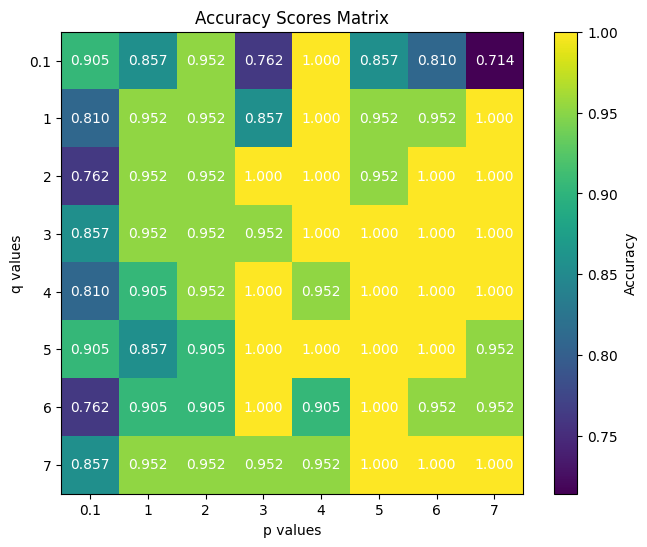

In [116]:
acc_matrix = np.array(acc_list).reshape(len(p_range), len(q_range))

plt.figure(figsize=(8, 6))
plt.imshow(acc_matrix, cmap='viridis', interpolation='nearest')

# Add labels and ticks
plt.title('Accuracy Scores Matrix')
plt.xlabel('p values')
plt.ylabel('q values')
plt.colorbar(label='Accuracy')

plt.xticks(np.arange(len(q_range)), q_range)
plt.yticks(np.arange(len(p_range)), p_range)

for i in range(len(p_range)):
    for j in range(len(q_range)):
        plt.text(j, i, f'{acc_matrix[i, j]:.3f}', ha='center', va='center', color='white')

# Show the plot
plt.show()

### Implementing a Film Recomender System

In [ ]:
# TODO